---
title: End of Quarter Analysis
author: Marvin (Wenxiang) Li
format:
    html:
        toc: true
        code-fold: true
embed-resources: true        
---

## **Project Overview**   
The end_of_quarter dataset was retrieved from the WCOLINE system report. The original data consisted of three separate tables: Appointment, Cancellation, and Client Report. These tables were generated based on students' tutoring appointment request forms. Initial data cleaning was performed in Excel, and the three tables were subsequently merged into a single comprehensive dataset. Note that appointments canceled by staff were excluded.

This analysis aims to identify the factors that contribute to students' decisions to cancel tutoring appointments. For example, the Random Forest model is normally used to predict outcomes based on a set of features. It can also indentify the most important features that influence the outcome using a SHAP summary.  

## 1. Loading the data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
end_of_quarter = pd.read_csv('quarter_end_1 (1).csv')

In [6]:
end_of_quarter.head(5)

,Full Name,School Year,School,Major,Housing,School Program,Sport Team,Location,Staff or Resource Name,Appointment Date,...,Length,Walk-In/Drop-In,Missed/No-Show/Canceled,Focus,Repeating,Online,Required,Hope,Level Prior,Level Prior.1
0,Gabriella Knudson,First-time First Year,OCOB,BUS,I live off campus,None |,NaN,"Learning Support Center (Bldg26, Rm110A)","Timbre D. (she, her, hers)",1/6/25,...,0.5,NO,ATTEND,A WRITING PROJECT or ASSIGNMENT,NO,NO,No,I want to get a good grade in the course,2,I'm somewhat confident that I will do well in ...
1,Lauren Grooms-Lee,Fourth Year,CLA,IS,I live off campus,None |,NaN,"Learning Support Center (Bldg26, Rm110A)","Carisa J. (she, her, hers)",1/6/25,...,0.5,NO,ATTEND,A WRITING PROJECT or ASSIGNMENT,NO,CHECKED,No,I want to better understand course material,2,I'm somewhat confident that I will do well in ...
2,Lauren Grooms-Lee,Fourth Year,CLA,IS,I live off campus,None |,NaN,"Learning Support Center (Bldg26, Rm110A)","Timbre D. (she, her, hers)",1/6/25,...,0.5,NO,ATTEND,A WRITING PROJECT or ASSIGNMENT,NO,CHECKED,No,I want to better understand course material,2,I'm somewhat confident that I will do well in ...
3,Lilly Salcedo,First-time First Year,CAFES,EESS,I live in Yosemite,None |,NaN,"Learning Support Center (Bldg26, Rm110A)","Gemma W. (she, her, hers)",1/6/25,...,0.5,NO,ATTEND,CHEM 127,NO,NO,No,I want to better understand course material,2,I'm somewhat confident that I will do well in ...
4,Maddy Bermudez,First-time First Year,OCOB,KINE,I live in yakityutyu,NCAA Student-Athlete |,Softball,"Learning Support Center (Bldg26, Rm110A)","Alex Y. (he, him, his)",1/6/25,...,0.5,NO,ATTEND,STAT 218,NO,NO,Yes,I want to get a good grade in the course,2,I'm somewhat confident that I will do well in ...


| Column Name                | Description                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| Full Name                 | Full name of the student.                                                  |
| School Year               | Academic year level (e.g., First Year, Sophomore, Post-Baccalaureate).     |
| School                    | College or department the student belongs to (e.g., CAFES, CENG).          |
| Major                     | Student’s declared major (e.g., Computer Science, Biology).                |
| Housing                   | Where the student lives (e.g., on-campus, off-campus, specific dorms).     |
| School Program            | Special programs student may belong to (e.g., EOP, Honors).                |
| Sport Team                | Athletic team the student participates in (if any).                        |
| Location                  | Physical or virtual location of the appointment.                           |
| Staff or Resource Name    | Name of the staff member or resource the appointment was with.             |
| Appointment Date          | Date the appointment was scheduled to occur.                               |
| QuarterBegin              | Date the academic quarter began.                                           |
| Days From Start           | Number of days between the quarter start and appointment date (replacing Appointment Date).             |
| Start Time                | Time the appointment started.                                              |
| Minutes of the day        | Numeric representation of start time in minutes from midnight (replacing Start Time).             |
| Length                    | Duration of the appointment in hours.                                    |
| Walk-In/Drop-In           | Indicates if it was a walk-in/drop-in appointment.                         |
| Missed/No-Show/Canceled   | Outcome of the appointment (e.g., attended, missed, canceled).             |
| Focus                     | Subject or topic the student focused on during the session.                |
| Repeating                 | Indicates if the student had repeated appointments.                        |
| Online                    | Indicates if the appointment was conducted online.                         |
| Required                  | Whether attendance was required for a course or program.                   |
| Hope                      | Student’s expressed hope or goal for attending (e.g., better grades).      |
| Level Prior               | Student’s prior knowledge level in number.                    |
| Level Prior.1             | Student’s prior knowledge level.     |


Creating a two class target variable to fit binary models.

In [7]:
def new_catergory(x):
  if x == 'NOSHOW' or x == 'CANCELED':
    return 'NOATTEND'
  else:
    return x

In [8]:
end_of_quarter['Attended'] = end_of_quarter['Missed/No-Show/Canceled'].apply(new_catergory)

In [9]:
end_of_quarter_trim = end_of_quarter.drop(columns=['Full Name',
      'Appointment Date', 'QuarterBegin',  'Start Time','Level Prior.1'])

## 2. Exploratory data analysis (EDA)

This step provides a holistic view of the composition of the dataset

In [10]:
def dataset_info(df):
    print("\n--- Shape of Data ---")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

    print("\n--- Data Types and Non-Nulls ---")
    print(df.info())

    print("\n--- First 5 Rows ---")
    print(df.head())


# 2. Missing Values
def missing_values_table(df):
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_table = pd.DataFrame({'Missing Values': missing, 'Percent': missing_percent})
    missing_table = missing_table[missing_table['Missing Values'] > 0]
    missing_table = missing_table.sort_values('Percent', ascending=False)

    if missing_table.empty:
        print("\nNo missing values detected.")
    else:
        print("\n--- Missing Values ---")
        print(missing_table)


# 3. Summary Stat
def summary_stats(df):
    print("\n--- Numerical Features ---")
    print(df.describe())

    print("\n--- Categorical Features ---")
    print(df.describe(include=['object']))


# 4. Duplicate Check
def check_duplicates(df):
    duplicates = df.duplicated().sum()
    print(f"\n--- Duplicates ---\nDuplicate Rows: {duplicates}")


#  5. Univariate Plots
import math

def univariate_plots(df):
    numeric_cols = df.select_dtypes(include=np.number).columns
    categorical_cols = df.select_dtypes(include='object').columns

    # Plot numeric distributions (2 per row)
    print("\n--- Numeric Distributions ---")
    n = len(numeric_cols)
    rows = math.ceil(n / 2)

    fig, axes = plt.subplots(rows, 2, figsize=(12, 3 * rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')

    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Plot categorical counts (2 per row)
    print("\n--- Categorical Counts ---")
    n = len(categorical_cols)
    rows = math.ceil(n / 2)

    fig, axes = plt.subplots(rows, 2, figsize=(12, 3 * rows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        df[col].value_counts().plot(kind='bar', ax=axes[i])
        axes[i].set_title(f'Counts of {col}')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



# 6. heatmap
def correlation_heatmap(df):
    numeric_cols = df.select_dtypes(include=np.number)
    if numeric_cols.shape[1] > 1:
        plt.figure(figsize=(10, 8))
        sns.heatmap(numeric_cols.corr(), annot=True, fmt='.2f', cmap='coolwarm')
        plt.title('Correlation Heatmap')
        plt.show()
    else:
        print("\nNot enough numeric columns for correlation heatmap.")


# run everything
def run_eda(df):
    dataset_info(df)
    missing_values_table(df)
    summary_stats(df)
    check_duplicates(df)
    univariate_plots(df)
    #correlation_heatmap(df)

    print("\nEDA Complete!")



In [11]:
# run_eda(end_of_quarter_trim)

### Initial EDA Results
1. Data Quality
   - Missing values are minimal:

   - Focus: 101 missing (2.0%)

   - School: 72 missing (1.4%)

2. Data Types  
   - 16 categorical (object) features

   - 3 numerical (int64) features

   - 1 float feature (Length)

3. Numerical Summary
   - Appointments span up to 72 days from the start of the quarter.

   - Appointments are mostly scheduled between 10:00 AM and 3:00 PM (Minutes of the day mean = 808).

   - Most sessions are 30 or 60 minutes, with a mean length of ~0.53 hours.

   - Level Prior ranges from 0 to 3.

4. Categorical Summary
   - School Year: Dominated by First-time First Year students (62.3%)

   - Majors: 67 unique majors, most common is BUS (988 records)

   - Housing: ~31% live in yakityutyu housing

   - Consultation Location: 95% take place at the Learning Support Center (Bldg26, Rm110A)

   - Staff: 77 unique staff members; Carisa J. is the most frequent

   - Cancellation Status: 3 categories, with 68% marked as “ATTEND”

5. Notable Patterns
   - Most students indicate they "want to better understand course material" as their reason for booking.

   - A majority of appointments are not repeating, not walk-ins, and not online consultations.

## 3. Additonal Cleaning

Two different target variables were created to fit different classification models. Classes are imbalance

In [12]:
end_of_quarter_trim['Missed/No-Show/Canceled'].value_counts(normalize=True)

Missed/No-Show/Canceled
ATTEND      0.682271
CANCELED    0.248008
NOSHOW      0.069721
Name: proportion, dtype: float64

In [13]:
end_of_quarter_trim['Attended'].value_counts(normalize=True)

Attended
ATTEND      0.682271
NOATTEND    0.317729
Name: proportion, dtype: float64

Filling NAs with "Unknown" for categorical variables.

In [14]:
end_of_quarter_trim['Sport Team']= end_of_quarter_trim['Sport Team'].fillna('None')
end_of_quarter_trim['School']= end_of_quarter_trim['School'].fillna('Unknown')
end_of_quarter_trim['Focus']= end_of_quarter_trim['Focus'].fillna('Unknown')
end_of_quarter_clean = end_of_quarter_trim.copy()

## 4. Modeling

In [15]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Preprocessing and modeling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Imbalanced data handling
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")


In [16]:
X = end_of_quarter_clean.drop(columns=['Missed/No-Show/Canceled', 'Attended'])
y = end_of_quarter_clean['Missed/No-Show/Canceled']

In [17]:
le = LabelEncoder()
y = le.fit_transform(y)

In [18]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### a. Random Forest

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/marvinlee/Documents/vs_code/gsb_544/gsb544env/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 5, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/marvinlee/Documents/vs_code/gsb_544/gsb544env/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/marvinlee/Documents/vs_code/gsb_544/gsb544env/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
/Users/marvinlee/Documents/vs_code/g

Best F1 Score: [0.7078823  0.7076794  0.66060761 0.7110717  0.73647712]
Mean F1 Score: 0.7047436280428985

Classification Report:
              precision    recall  f1-score   support

      ATTEND       0.90      0.97      0.94       672
    CANCELED       1.00      1.00      1.00       255
      NOSHOW       0.28      0.10      0.15        77

    accuracy                           0.91      1004
   macro avg       0.73      0.69      0.70      1004
weighted avg       0.88      0.91      0.89      1004



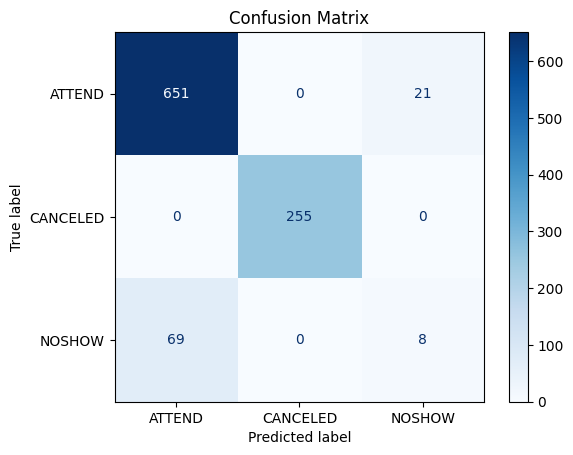

In [20]:
# Define the preprocessing transformer
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
    ('num', 'passthrough', num_cols)
])

# Build the pipeline with preprocessing, SMOTE, and classifier
pipeline_rf = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 5))
])

# Cross-validation
results = cross_validate(pipeline_rf,X_train, y_train,  cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
print("Best F1 Score:", results['test_score'])
print("Mean F1 Score:", results['test_score'].mean())

# Predict on test set
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

#### 1. Random Forest Performance Summary

This multi-class Random Forest classification model was developed to predict tutoring appointment outcomes: **ATTEND**, **CANCELED**, or **NOSHOW**. The model was trained using cross-validation with SMOTE and evaluated on a held-out test set.  

**Cross-validation results** showed consistent performance across folds, with a **mean macro F1 score of 0.717**, indicating balanced effectiveness across the three classes during training.  

On the **test set**, the model achieved:  
- **Overall accuracy**: **90%**  
- **Weighted F1 score**: **0.89**  

The model performed **exceptionally well** in identifying both **ATTEND** and **CANCELED** appointments:  
- **CANCELED**: Perfect precision and recall (**F1 = 1.00**)  
- **ATTEND**: Very strong performance (**F1 = 0.94**)  

However, the model struggled with the **NOSHOW** class:  
- **Precision**: 0.28  
- **Recall**: 0.10  
- **F1 Score**: 0.15  

This indicates that the model frequently **fails to detect no-shows**, likely due to **class imbalance**, limited training examples, or feature overlap with the other two outcomes.  

The **macro-average F1 score of 0.70** reflects this disparity, highlighting the need for targeted improvements to better capture patterns associated with NOSHOW behavior.  


In [21]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# STEP 1: Fit the pipeline
pipeline_rf.fit(X_train, y_train)

# STEP 2: Clean unknown categories in X_test
X_test_fixed = X_test.copy()
for col in cat_cols:
    known = set(X_train[col].dropna().unique())
    X_test_fixed[col] = X_test_fixed[col].apply(lambda x: x if x in known else 'unknown')

# STEP 3: Transform X_test through the preprocessor
preprocessor = pipeline_rf.named_steps['preprocessor']
X_preprocessed = preprocessor.transform(X_test_fixed)

# STEP 4: Convert to dense float32
if hasattr(X_preprocessed, 'toarray'):
    X_preprocessed = X_preprocessed.toarray()
X_preprocessed = X_preprocessed.astype(np.float32)

# STEP 5: Get proper feature names
ohe = preprocessor.named_transformers_['cat']
encoded_cat_features = ohe.get_feature_names_out(cat_cols)
all_features = list(num_cols) + list(encoded_cat_features)

# STEP 6: Get trained RF model and explain with SHAP
rf_model = pipeline_rf.named_steps['classifier']
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_preprocessed)  # list of arrays, one per class

# STEP 7: Validate and plot
print(f"\nSHAP returned {len(shap_values)} classes. Each should match shape {X_preprocessed.shape}")


SHAP returned 1004 classes. Each should match shape (1004, 362)


#### Random Forest SHAP Summary plot
The summary plot combines feature importance with feature effects. Each point on the plot is a Shapley value for a feature and an instance. The plot orders features by importance (mean |SHAP|) and shows how feature values impact the model output.


📊 SHAP Summary for Class: ATTEND


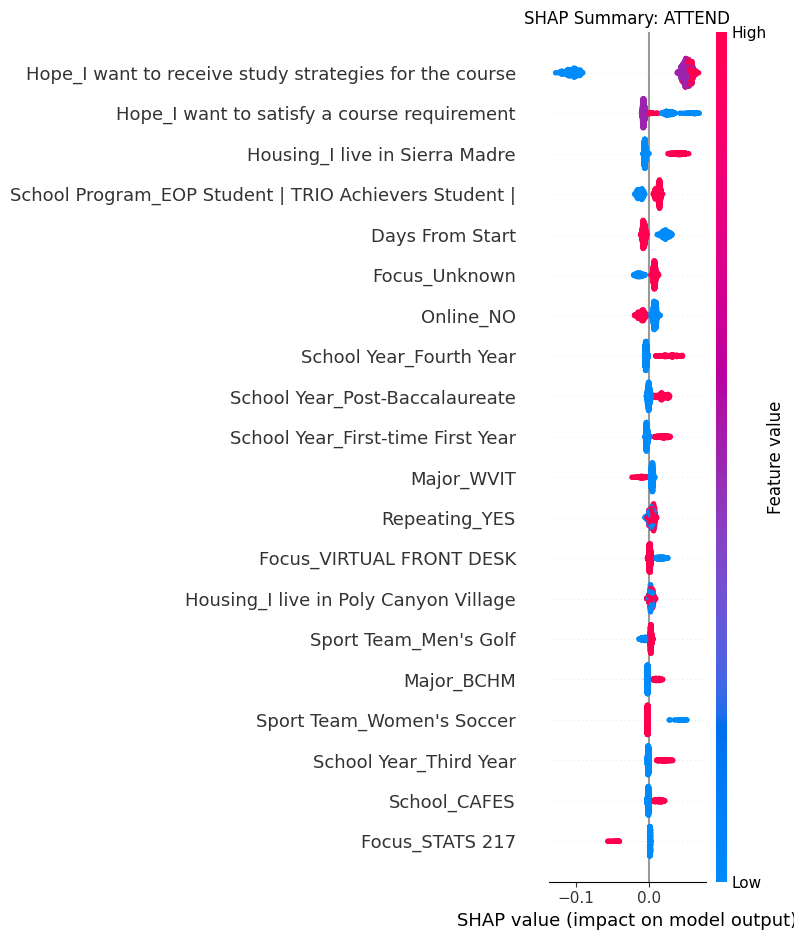


📊 SHAP Summary for Class: CANCELED


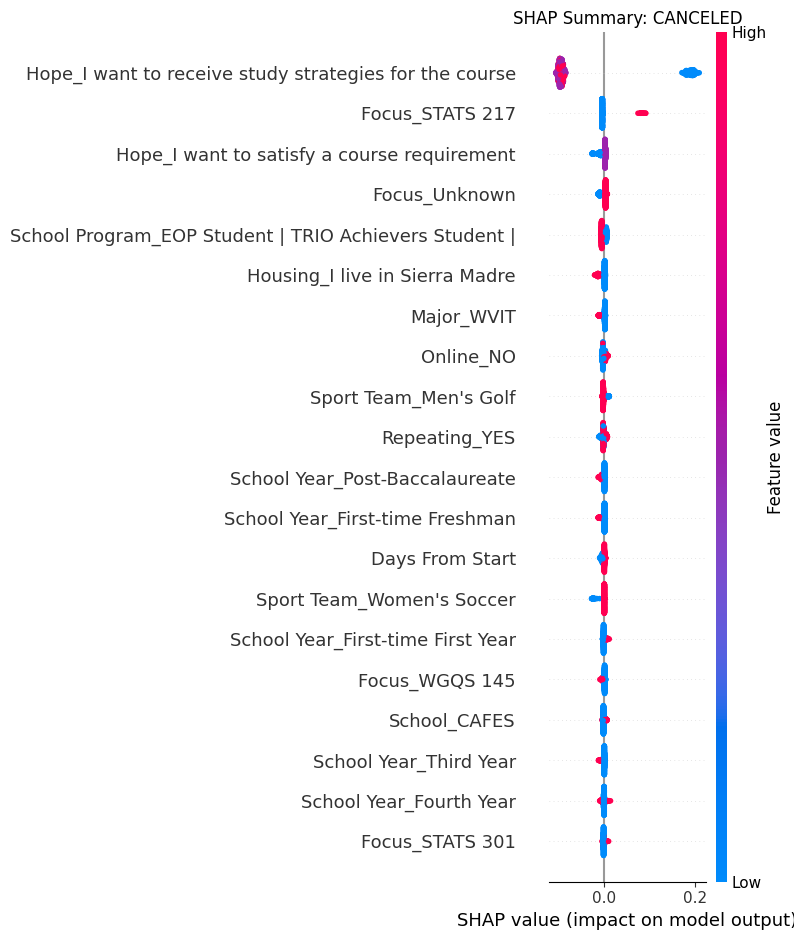


📊 SHAP Summary for Class: NOSHOW


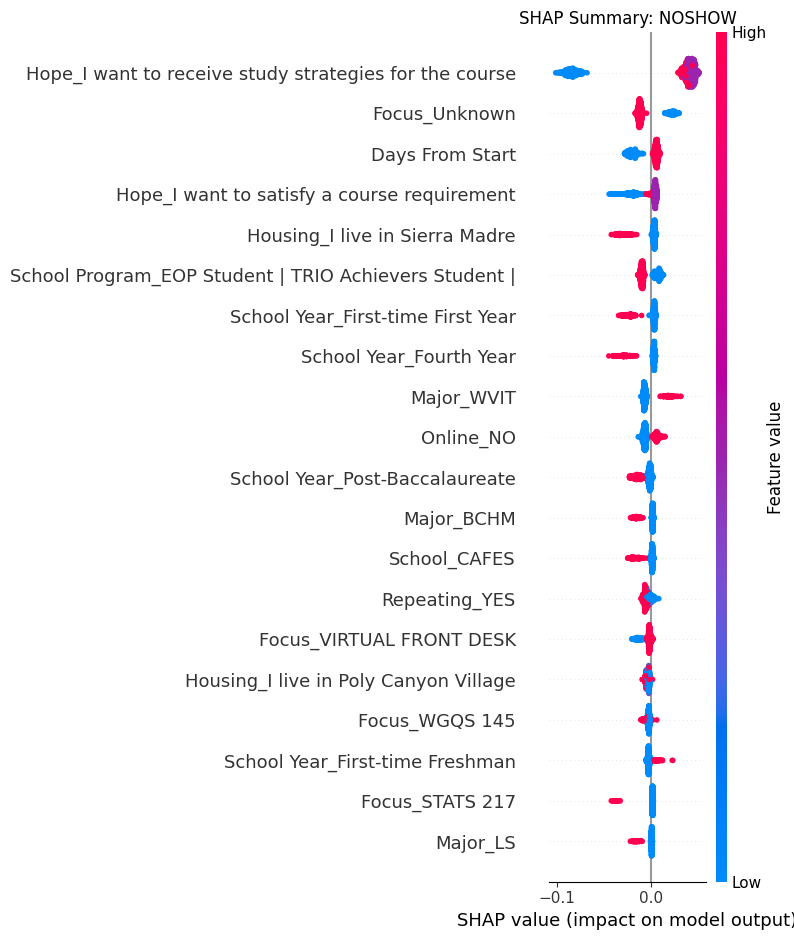

In [22]:
class_names = le.classes_

for i, class_name in enumerate(class_names):
    print(f"\n📊 SHAP Summary for Class: {class_name}")
    shap.summary_plot(shap_values[..., i], X_preprocessed, feature_names=all_features, show=False)
    plt.title(f"SHAP Summary: {class_name}")
    plt.tight_layout()
    plt.show()


In [23]:
import pandas as pd
import numpy as np

# shap_values has shape (n_samples, n_features, n_classes)
# all_features is your list of feature names
class_names = le.classes_

# Create a summary DataFrame for each class
summary_tables = {}

for class_idx, class_name in enumerate(class_names):
    class_shap = shap_values[..., class_idx]  # (n_samples, n_features)

    # ✅ Recompute both absolute and signed SHAP values here
    mean_abs_shap = np.abs(class_shap).mean(axis=0)
    mean_signed_shap = class_shap.mean(axis=0)

    summary_df = pd.DataFrame({
        'Feature': all_features,
        'Mean |SHAP|': mean_abs_shap,
        'Mean SHAP (Signed)': mean_signed_shap
    }).sort_values(by='Mean |SHAP|', ascending=False)

    summary_tables[class_name] = summary_df

    print(f"\n🔍 Top 10 SHAP Features for Class: {class_name}")
    display(summary_df.head(5))



🔍 Top 10 SHAP Features for Class: ATTEND


,Feature,Mean |SHAP|,Mean SHAP (Signed)
360,Hope_I want to receive study strategies for th...,0.066832,0.013046
361,Hope_I want to satisfy a course requirement,0.014193,0.005072
84,Housing_I live in Sierra Madre,0.013405,0.005848
93,School Program_EOP Student | TRIO Achievers St...,0.013042,0.003858
0,Days From Start,0.012789,0.004573



🔍 Top 10 SHAP Features for Class: CANCELED


,Feature,Mean |SHAP|,Mean SHAP (Signed)
360,Hope_I want to receive study strategies for th...,0.118834,-0.022372
347,Focus_STATS 217,0.005612,-0.001801
361,Hope_I want to satisfy a course requirement,0.004719,-0.001450
351,Focus_Unknown,0.004622,0.001180
93,School Program_EOP Student | TRIO Achievers St...,0.004267,-0.000941



🔍 Top 10 SHAP Features for Class: NOSHOW


,Feature,Mean |SHAP|,Mean SHAP (Signed)
360,Hope_I want to receive study strategies for th...,0.052002,0.009326
351,Focus_Unknown,0.013808,-0.005212
0,Days From Start,0.011146,-0.003726
361,Hope_I want to satisfy a course requirement,0.009502,-0.003623
84,Housing_I live in Sierra Madre,0.009356,-0.004075


#### 2. Random Forest SHAP Interpretation

#### Class: ATTEND

The model identifies the following features as most influential in **increasing the probability of a student attending** their appointment:

- **Hope: Receive study strategies** — Strongest positive influence on attendance
- **Hope: Satisfy course requirement** — Positively associated with attendance
- **Housing: Sierra Madre** — Mildly associated with attending
- **School Program: EOP / TRIO** — Positively associated with attendance
- **Days From Start** — Slightly more likely to attend

> Most top features have **positive SHAP values**, meaning they increase the likelihood of attendance.

---

#### Class: CANCELED

The strongest contributors to cancellation are features that actually **reduce the likelihood** of a canceled appointment:

- **Hope: Receive study strategies** — Strong **negative SHAP**, decreases cancellation 
- **Focus: STAT 217** — Mildly associated with lower cancellation
- **Hope: Satisfy course requirement** — Slight negative influence on cancellation
- **Focus: Unknown** — Minor positive influence on cancellations
- **School Program: EOP / TRIO** — Minor negative influence on cancellation

> The model does not find strong features that push toward cancellation; rather, it identifies factors that reduce the likelihood of cancellation.

---

#### Class: NOSHOW

The most important predictors for the no-show class include a **mix of factors** pushing toward and away from the class:

- **Hope: Receive study strategies** — Slightly **increases** the likelihood of no-show
- **Focus: Unknown** — Slight **negative** influence on no-show 
- **Days From Start** — Slight negative influence on no-show
- **Hope: Satisfy course requirement** — Mildly decreases the likelihood of no-show
- **Housing: Sierra Madre** — Slight reduction in no-show 

>  The **NOSHOW** class is influenced by a **broader mix of weaker signals**, suggesting it's more difficult to predict.

---

#### Key Takeaways

- The **“Hope” variable**, particularly "receive study strategies", is consistently the most influential feature across all classes.
- **CANCELED** is primarily influenced by what reduces its likelihood rather than features directly associated with cancellation.
- **NOSHOW** is harder to model, with small and mixed directional effects, indicating that predicting no-shows is more complex.


#### b. Logistic Regression (WIP)